# Multi-modal Deception Detection using Deep Learning

Audio, Micro-expression and Gaze Features extracted from Opensmile and Openface is combined. The various combinations are Audio+Micro-expression; Audio+Gaze; Gaze+Micro-expression; Audio+Micro-expression+Gaze


### Import all necessary packages

In [0]:
import os
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import os, sys, glob, csv, keras
from sklearn import model_selection, preprocessing
from os import walk, path
from keras import models, layers, optimizers, preprocessing as KRSpreps, utils as KRSutils
#from tslearn import preprocessing as TSpreps, utils as TSutils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
from __future__ import absolute_import, division, print_function

from tensorflow.keras.layers import Lambda, Input, Dense, Flatten, Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

#import numpy as np, matplotlib.pyplot as plt, argparse, os

In [0]:
from tensorflow import keras
import tempfile

import matplotlib as mpl
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from glob import glob
import datetime

### Create Dictionary and store paths for all different Modalities(Audio, Micro-expression and Gaze)

In [0]:
data_path = {}
data_path['audiodata_path'] = "Audio_Features/csv_framewise_audio/"
data_path['gazedata_path'] = "Gaze_Features/"
data_path['mexpdata_path'] = "Mexp_Features/"

### Checking No. of files in each of Audio, Micro-expression & Gaze Folders && Shape of the Dataframes

In [0]:
data_shape_all = pd.DataFrame()
for key in data_path.keys():
    count = 0
    data_shape, file_names = [], []
    for filepath in glob(path.join(data_path[key], '*.csv')):
        file_shape = pd.read_csv(filepath).shape
        filename = path.basename(filepath)
        for reps in (("Gaze_", ""), ("Audio_", ""), ("Mexp_", "")):
            filename = filename.replace(*reps)
        if filename not in ['Annotation_mexp_features.csv', 'Annotation_gaze_features.csv', 'Youtube_splitsteal_deception_user5_3.csv']:
            data_shape.append([file_shape[0], file_shape[1]])
            file_names.append(filename)
            count+=1
    data_shape = pd.DataFrame(data_shape)
    data_shape.columns = [key + str(0), key +str(1)]
    data_shape.index = pd.Series(file_names)
    data_shape_all = pd.concat([data_shape_all, data_shape], axis = 1, sort=True)
    print(f"No. of file in {key}: ", count)
#data_shape_all

No. of file in audiodata_path:  657
No. of file in gazedata_path:  657
No. of file in mexpdata_path:  657


## Creating Dictionaries of Audio, Micro-expression & Gaze
Remove Initials and Make the Keys Same for the Same data

In [0]:
audio_dict, gaze_dict, mexp_dict = {}, {}, {}
listofdicts = [audio_dict, gaze_dict, mexp_dict]
for key, data_dict_indiv in zip(data_path.keys(), listofdicts):
    for filepath in glob(path.join(data_path[key], '*.csv')):
        data = pd.read_csv(filepath)
        filename = path.basename(filepath)
        for reps in (("Gaze_", ""), ("Audio_", ""), ("Mexp_", "")):
            filename = filename.replace(*reps)
        data_dict_indiv[filename] = data

### Checking If the Labels are Same for Same Keys in Each Dcitionaries & Separating Labels from Training Data

In [0]:
filename_dictkeys = list(audio_dict)
label_dict = {}
for key in filename_dictkeys:
    audiodata, gazedata, mexpdata = audio_dict[key], gaze_dict[key], mexp_dict[key]
    label_audio = audiodata.loc[:, "label"].unique()[0]
    label_gaze = gazedata.loc[:, "label"].unique()[0]
    label_mexp = mexpdata.loc[:, "label"].unique()[0]
    label_set = set([label_audio, label_gaze, label_mexp])
    if len(label_set) > 1:
        print(key)
    else:
        label_dict[key] = list(label_set)[0]

### Dropping Indexing Columns & Labels from Training Data && Reindexing with TIme && Upsampling

In [0]:
from scipy.signal import resample

filename_dictkeys = list(audio_dict)
audio_dict_upsampled, gaze_dict_upsampled, mexp_dict_upsampled = {}, {}, {}
for key in filename_dictkeys:
    audio_data = np.array(audio_dict[key].drop(["name", "frameTime", "Unnamed: 0", "label"], axis = 1).drop_duplicates())
    audio_dict_upsampled[key] = resample(audio_data, 300)
    gaze_data = np.array(gaze_dict[key].drop(["frame", "Unnamed: 0", "label"], axis = 1).drop_duplicates())
    gaze_dict_upsampled[key] = resample(gaze_data, 300)
    mexp_data = np.array(mexp_dict[key].drop(["frame", "Unnamed: 0", "label"], axis = 1).drop_duplicates())
    mexp_dict_upsampled[key] = resample(mexp_data, 300)

### Splitting Train and Test keys

In [0]:
import random
random.seed(3986)
train_split_keys = random.sample(list(audio_dict_upsampled), int(0.75*len(list(audio_dict_upsampled))))
test_split_keys = list(set(list(audio_dict_upsampled)) - set(train_split_keys))

### Splitting Train and Test data for Gaze, Audio, Micro-expression data

In [0]:
dict_split_train = lambda dict_data: {key: value for key, value in dict_data.items() if key in train_split_keys}
dict_split_test = lambda dict_data: {key: value for key, value in dict_data.items() if key in test_split_keys}

mapped_train = list(map(dict_split_train, [audio_dict_upsampled, gaze_dict_upsampled, mexp_dict_upsampled, label_dict]))
mapped_test = list(map(dict_split_test, [audio_dict_upsampled, gaze_dict_upsampled, mexp_dict_upsampled, label_dict]))

train_data = {'audio_train': mapped_train[0], 'gaze_train': mapped_train[1], 
              'mexp_train': mapped_train[2], 'y_train': mapped_train[3]}
test_data = {'audio_test': mapped_test[0], 'gaze_test': mapped_test[1], 'mexp_test': mapped_test[2], 'y_test': mapped_test[3]}

In [0]:
conv2arr = lambda x: np.array(x)

train_data['audio_train'] = conv2arr(list(train_data['audio_train'].values()))
test_data['audio_test'] = conv2arr(list(test_data['audio_test'].values()))

train_data['gaze_train'] = conv2arr(list(train_data['gaze_train'].values()))
test_data['gaze_test'] = conv2arr(list(test_data['gaze_test'].values()))

train_data['mexp_train'] = conv2arr(list(train_data['mexp_train'].values()))
test_data['mexp_test'] = conv2arr(list(test_data['mexp_test'].values()))

train_data['y_train'] = conv2arr(list(train_data['y_train'].values()))
test_data['y_test'] = conv2arr(list(test_data['y_test'].values()))

### Removing Ground Truth Values from && scaling data

In [0]:
train_key, test_key = list(train_data.keys()), list(test_data.keys())
train_key.remove('y_train')
test_key.remove('y_test')

for key1, key2 in zip(train_key, test_key):
    scaler = StandardScaler()
    data1, data2 = train_data[key1], test_data[key2]

    s0, s1, s2 = data1.shape[0], data1.shape[1], data1.shape[2]
    print(data1.shape)
    data1 = data1.reshape(s0*s1, s2)
    data1 = scaler.fit_transform(data1)
    print(data1.shape)
    train_data[key1] = data1.reshape(s0, s1, s2)

    s0, s1, s2 = data2.shape[0], data2.shape[1], data2.shape[2]
    print(data2.shape)
    data2 = data2.reshape(s0*s1, s2)
    data2 = scaler.transform(data2)
    print(data2.shape)
    test_data[key2] = data2.reshape(s0, s1, s2)
    print(data1.shape, data2.shape)

(492, 300, 26)
(147600, 26)
(165, 300, 26)
(49500, 26)
(147600, 26) (49500, 26)
(492, 300, 292)
(147600, 292)
(165, 300, 292)
(49500, 292)
(147600, 292) (49500, 292)
(492, 300, 45)
(147600, 45)
(165, 300, 45)
(49500, 45)
(147600, 45) (49500, 45)


### Finally printing the shape of data(train and test) from different modalities

In [93]:
audio_features = train_data['audio_train'].copy()
test_audio_features = test_data['audio_test'].copy()

gaze_features = train_data['gaze_train'].copy()
test_gaze_features = test_data['gaze_test'].copy()

mexp_features = train_data['mexp_train'].copy()
test_mexp_features = test_data['mexp_test'].copy()

audio_features = np.clip(audio_features, -5, 5)
gaze_features = np.clip(gaze_features, -5, 5)
mexp_features = np.clip(mexp_features, -5, 5)

test_audio_features = np.clip(test_audio_features, -5, 5)
test_gaze_features = np.clip(test_gaze_features, -5, 5)
test_mexp_features = np.clip(test_mexp_features, -5, 5)

print('Audio train shape:', audio_features.shape)
print('Gaze train shape:', gaze_features.shape)
print('Mexp train shape:', mexp_features.shape)

print('Audio test shape:', test_audio_features.shape)
print('Gaze test shape:', test_gaze_features.shape)
print('mexp test shape:', test_mexp_features.shape)

Audio train shape: (492, 300, 26)
Gaze train shape: (492, 300, 292)
Mexp train shape: (492, 300, 45)
Audio test shape: (165, 300, 26)
Gaze test shape: (165, 300, 292)
mexp test shape: (165, 300, 45)


### Encoding Truthful and deceptive ground truth values

In [0]:
y_train = pd.Series(train_data['y_train']).apply(lambda value: 0 if value == 'Truthful' else 1)
y_test = pd.Series(test_data['y_test']).apply(lambda value: 0 if value == 'Truthful' else 1)

### Functions defined to calculate metrics, Confusion Matrix and plot Region of Convergence

In [0]:
def plot_metrics(history):
    mpl.rcParams['figure.figsize'] = (12, 10)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    metrics =  ['loss', 'auc', 'precision', 'recall']
    i = 0
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[i], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([-.005, 1.05])
        else:
            plt.ylim([0,1])
        plt.legend()
        i+=1

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
    mpl.rcParams['figure.figsize'] = (12, 10)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.plot([-0.5, 100.5], [-0.5, 100.5], color='navy', linewidth=2, linestyle='--')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5, 100.5])
    plt.ylim([-0.5, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

## Different models is defined so that it can be reused for various combinations of Gaze, Audio and Micro-expression
unimod function has 2 dense layers

unimod_lstm function has 2 lstm and 2 dense layer

multimod function takes combined data as input and generates output

In [0]:
# Regular model
METRICS = [keras.metrics.TruePositives(name='tp'), keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'), keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'), keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'), keras.metrics.AUC(name='auc')]

def unimod(data):
    input_data = Input(shape = (data.shape[1], data.shape[2]))
    x = Flatten()(input_data)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    model = Model(inputs = input_data, outputs=x)
    return model

def unimod_lstm(data):
    input_data = Input(shape = (data.shape[1], data.shape[2]))
    x = LSTM(128, recurrent_dropout=0.2, dropout=0.1, return_sequences=True)(input_data)
    x = LSTM(128, recurrent_dropout=0.2, dropout=0.1)(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    model = Model(inputs = input_data, outputs=x)
    return model

def multimod(combined):
    out = tf.keras.layers.Dense(128, activation="relu")(combined)
    out = tf.keras.layers.Dropout(0.2)(out)
    out = tf.keras.layers.Dense(128, activation="relu")(combined)
    out = tf.keras.layers.Dropout(0.2)(out)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(out)
    return out

### "unimod" function is used to treat data for individual modality then output from unimod is concatenated, finally multimod is used to combine different permutations of the modalities

In [0]:
# combine the output of the three branches
audio = unimod(audio_features)
gaze = unimod(gaze_features)
mexp = unimod(mexp_features)

combined_ag = tf.keras.layers.concatenate([audio.output, gaze.output], axis = 1)
combined_gm = tf.keras.layers.concatenate([gaze.output, mexp.output], axis = 1)
combined_am = tf.keras.layers.concatenate([audio.output, mexp.output], axis = 1)
combined_agm = tf.keras.layers.concatenate([audio.output, gaze.output, mexp.output], axis = 1)

inp, out = {}, {}
inp['ag'], inp['gm'], inp['am'], inp['agm'] = [audio.input, gaze.input], [gaze.input, mexp.input], [audio.input, mexp.input], [audio.input, gaze.input, mexp.input]
out['ag'], out['gm'], out['am'], out['agm'] = multimod(combined_ag), multimod(combined_gm), multimod(combined_am), multimod(combined_agm)

trainX, testX = {}, {}
trainX['ag'], trainX['gm'], trainX['am'], trainX['agm'] = [audio_features, gaze_features], [gaze_features, mexp_features], [audio_features, mexp_features], [audio_features, gaze_features, mexp_features]
testX['ag'], testX['gm'], testX['am'], testX['agm'] = [test_audio_features, test_gaze_features], [test_gaze_features, test_mexp_features], [test_audio_features, test_mexp_features], [test_audio_features, test_gaze_features, test_mexp_features]

### Earlystopping is used && best model from each combination is saved

Metric scores, Confusion Matrix, ROC for all 4 combination of modalities are displayed

For the Modalities: Audio-Gaze
[INFO] training model...
Train on 492 samples, validate on 165 samples
Epoch 1/100
480/492 [============================>.] - ETA: 0s - loss: 0.8523 - tp: 204.0000 - fp: 17.0000 - tn: 245.0000 - fn: 14.0000 - accuracy: 0.9354 - precision: 0.9231 - recall: 0.9358 - auc: 0.9628
Epoch 00001: val_auc improved from inf to 0.59610, saving model to best_modelag.h5
492/492 [==============================] - 5s 10ms/sample - loss: 0.8396 - tp: 212.0000 - fp: 17.0000 - tn: 248.0000 - fn: 15.0000 - accuracy: 0.9350 - precision: 0.9258 - recall: 0.9339 - auc: 0.9636 - val_loss: 5.8865 - val_tp: 39.0000 - val_fp: 37.0000 - val_tn: 56.0000 - val_fn: 33.0000 - val_accuracy: 0.5758 - val_precision: 0.5132 - val_recall: 0.5417 - val_auc: 0.5961
Epoch 2/100
480/492 [============================>.] - ETA: 0s - loss: 0.4674 - tp: 210.0000 - fp: 5.0000 - tn: 253.0000 - fn: 12.0000 - accuracy: 0.9646 - precision: 0.9767 - recall: 0.9459 - auc: 0.9811
Epoch 00002: val_auc did n

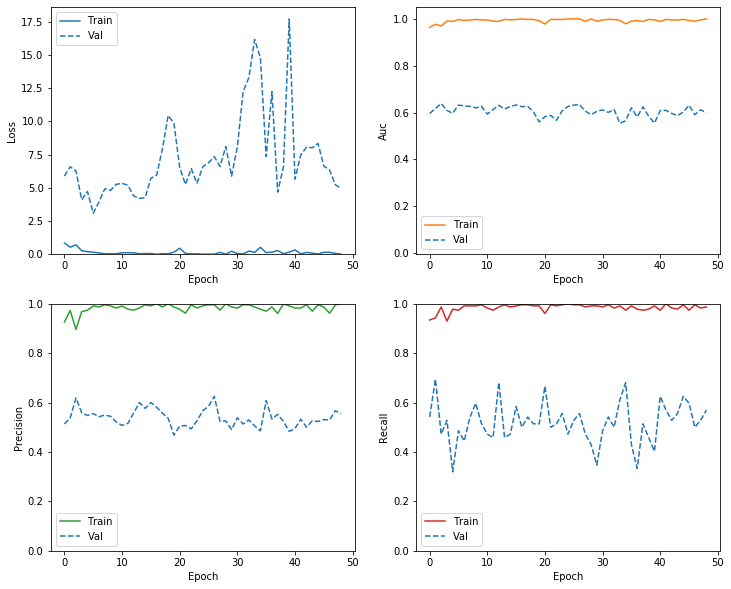

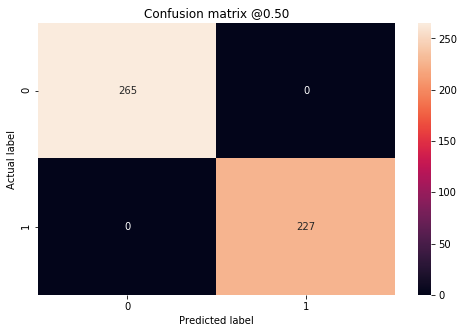

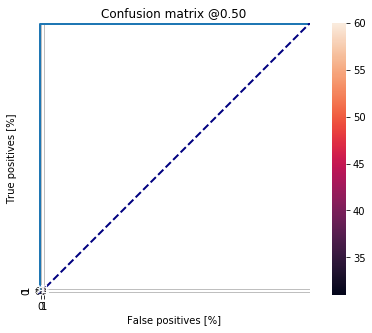

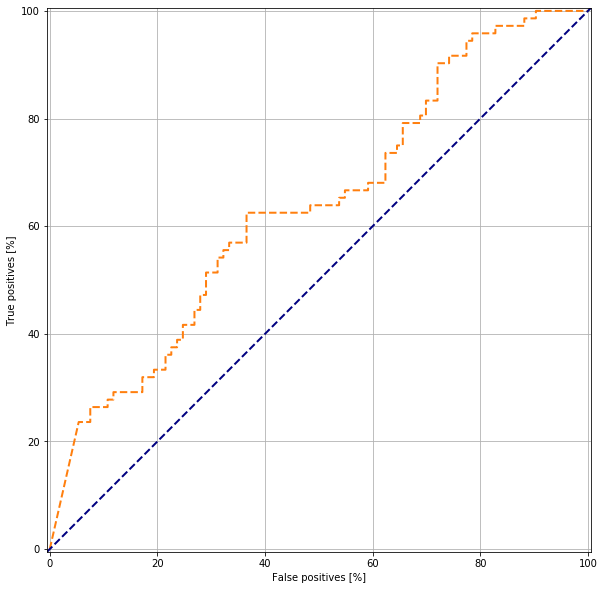

No handles with labels found to put in legend.


For the Modalities: Gaze-Mexp
[INFO] training model...
Train on 492 samples, validate on 165 samples
Epoch 1/100
480/492 [============================>.] - ETA: 0s - loss: 1.1355 - tp: 204.0000 - fp: 23.0000 - tn: 235.0000 - fn: 18.0000 - accuracy: 0.9146 - precision: 0.8987 - recall: 0.9189 - auc: 0.9428
Epoch 00001: val_auc improved from inf to 0.54854, saving model to best_modelgm.h5
492/492 [==============================] - 5s 10ms/sample - loss: 1.1079 - tp: 209.0000 - fp: 23.0000 - tn: 242.0000 - fn: 18.0000 - accuracy: 0.9167 - precision: 0.9009 - recall: 0.9207 - auc: 0.9443 - val_loss: 7.5176 - val_tp: 29.0000 - val_fp: 31.0000 - val_tn: 62.0000 - val_fn: 43.0000 - val_accuracy: 0.5515 - val_precision: 0.4833 - val_recall: 0.4028 - val_auc: 0.5485
Epoch 2/100
480/492 [============================>.] - ETA: 0s - loss: 0.5209 - tp: 204.0000 - fp: 7.0000 - tn: 252.0000 - fn: 17.0000 - accuracy: 0.9500 - precision: 0.9668 - recall: 0.9231 - auc: 0.9736
Epoch 00002: val_auc did no

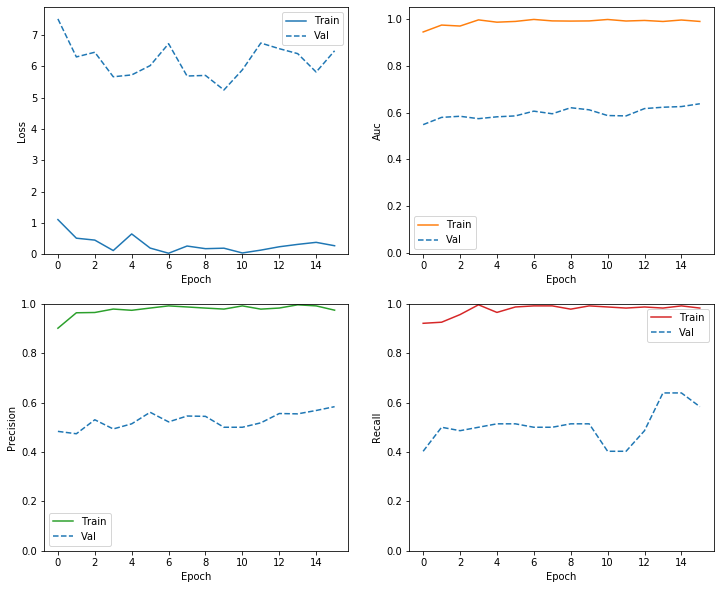

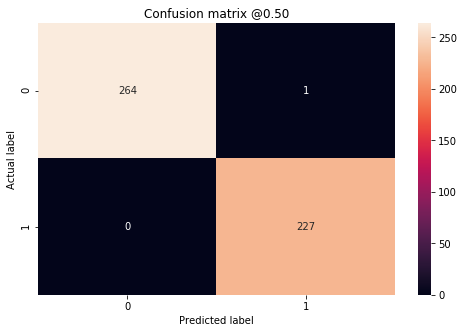

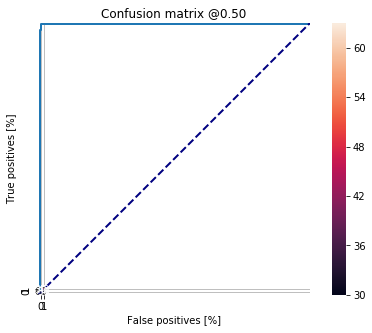

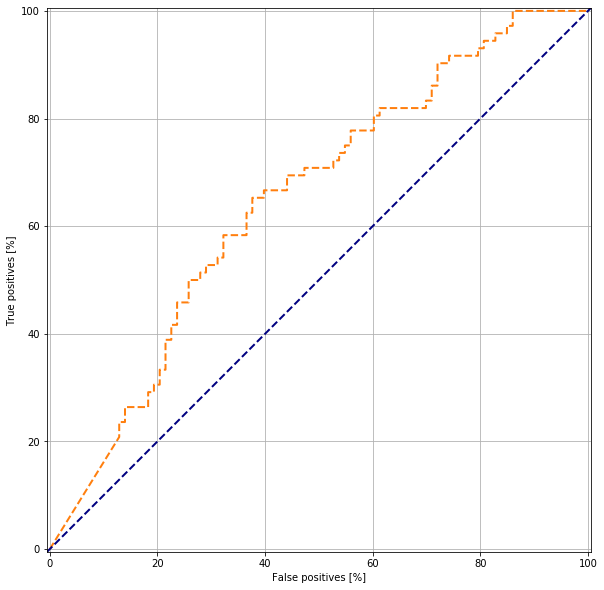

No handles with labels found to put in legend.


For the Modalities: Audio-Mexp
[INFO] training model...
Train on 492 samples, validate on 165 samples
Epoch 1/100
416/492 [========================>.....] - ETA: 0s - loss: 1.8778e-14 - tp: 193.0000 - fp: 0.0000e+00 - tn: 223.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 00001: val_auc improved from inf to 0.64740, saving model to best_modelam.h5
492/492 [==============================] - 4s 7ms/sample - loss: 1.5877e-14 - tp: 227.0000 - fp: 0.0000e+00 - tn: 265.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 16.4312 - val_tp: 37.0000 - val_fp: 24.0000 - val_tn: 69.0000 - val_fn: 35.0000 - val_accuracy: 0.6424 - val_precision: 0.6066 - val_recall: 0.5139 - val_auc: 0.6474
Epoch 2/100
416/492 [========================>.....] - ETA: 0s - loss: 4.9734e-15 - tp: 193.0000 - fp: 0.0000e+00 - tn: 223.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.

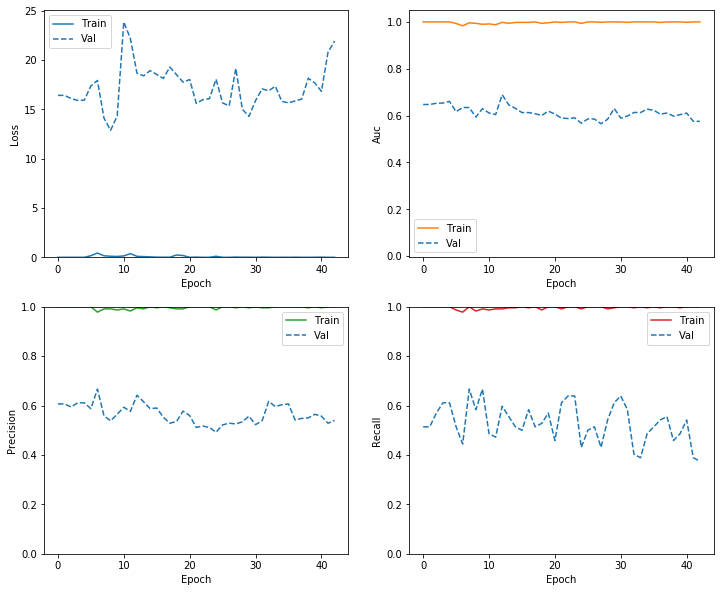

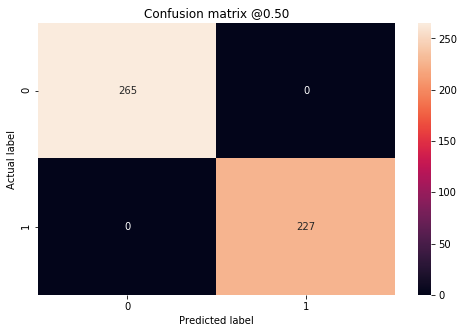

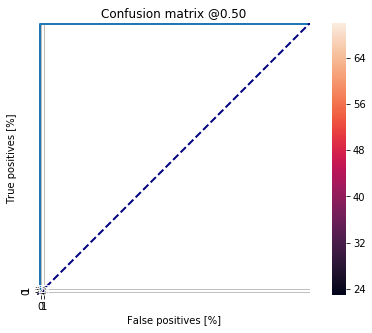

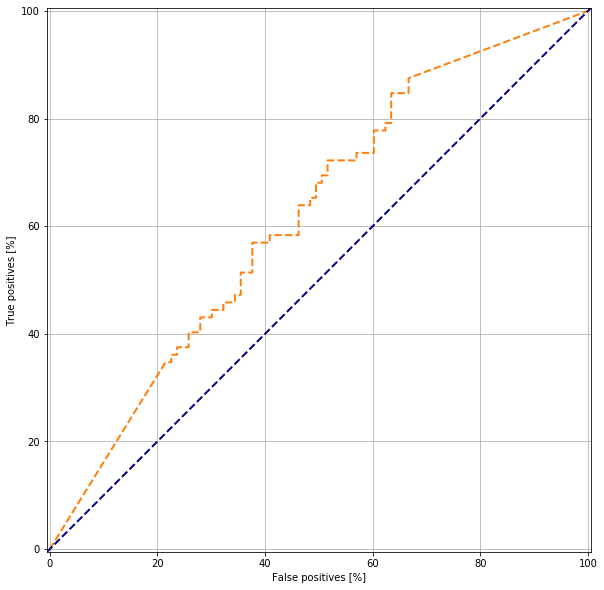

No handles with labels found to put in legend.


For the Modalities: Audio-Gaze-Mexp
[INFO] training model...
Train on 492 samples, validate on 165 samples
Epoch 1/100
480/492 [============================>.] - ETA: 0s - loss: 0.0178 - tp: 220.0000 - fp: 0.0000e+00 - tn: 259.0000 - fn: 1.0000 - accuracy: 0.9979 - precision: 1.0000 - recall: 0.9955 - auc: 0.9977        
Epoch 00001: val_auc improved from inf to 0.57027, saving model to best_modelagm.h5
492/492 [==============================] - 6s 12ms/sample - loss: 0.0173 - tp: 226.0000 - fp: 0.0000e+00 - tn: 265.0000 - fn: 1.0000 - accuracy: 0.9980 - precision: 1.0000 - recall: 0.9956 - auc: 0.9978 - val_loss: 30.5981 - val_tp: 33.0000 - val_fp: 29.0000 - val_tn: 64.0000 - val_fn: 39.0000 - val_accuracy: 0.5879 - val_precision: 0.5323 - val_recall: 0.4583 - val_auc: 0.5703
Epoch 2/100
480/492 [============================>.] - ETA: 0s - loss: 4.2664e-14 - tp: 221.0000 - fp: 0.0000e+00 - tn: 259.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0

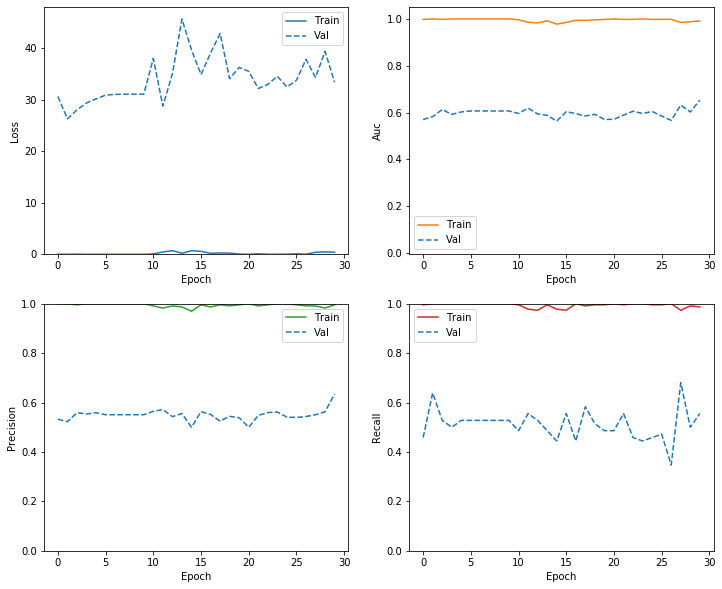

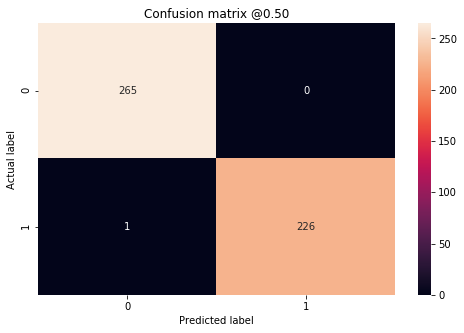

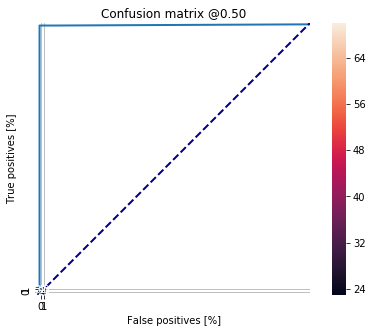

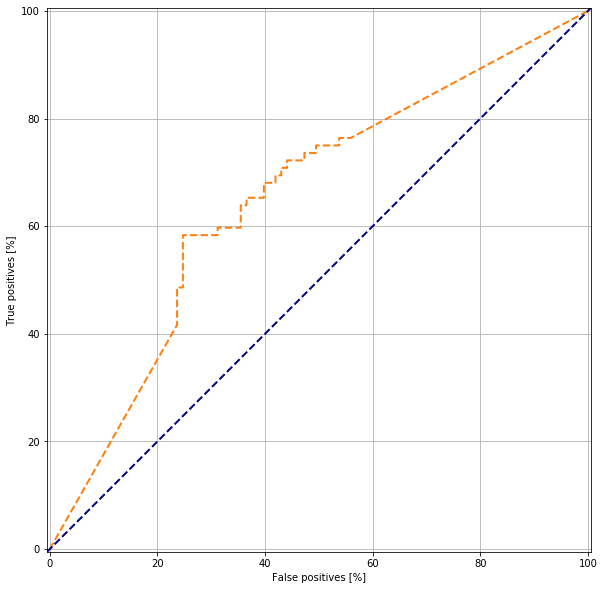

No handles with labels found to put in legend.


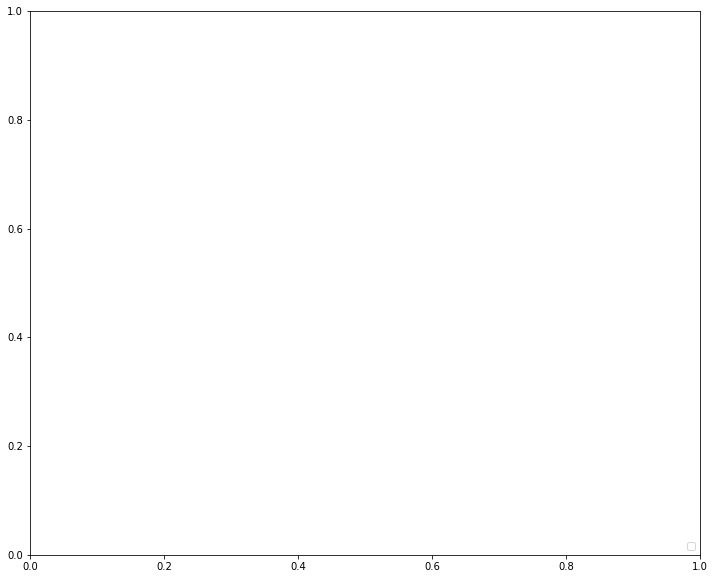

In [87]:
modaltypes = {'ag': 'Audio-Gaze', 'gm': 'Gaze-Mexp', 'am': 'Audio-Mexp', 'agm': 'Audio-Gaze-Mexp'}

for modaltype in ['ag', 'gm', 'am', 'agm']:
    print(f'For the Modalities: {modaltypes[modaltype]}')
    erstop = EarlyStopping(monitor='val_auc', mode='auto', verbose=1, patience=15)
    mdchck = ModelCheckpoint('best_model' +modaltype + '.h5', monitor='val_auc', mode='auto', verbose=1, save_best_only=True) 

    model = Model(inputs=inp[modaltype], outputs=out[modaltype])
    model.compile(optimizer = keras.optimizers.Adam(lr=1e-3), loss = keras.losses.BinaryCrossentropy(), metrics = METRICS)

    # train the model
    print("[INFO] training model...")
    history = model.fit(trainX[modaltype], y_train, validation_data = (testX[modaltype], y_test), epochs=100, callbacks = [erstop, mdchck])

    plot_metrics(history)
    plt.savefig('Loss_plot_' + modaltypes[modaltype] +'.png')

    #train_predictions_baseline = model.predict(trainX[modaltype])
    test_predictions_baseline = model.predict(testX[modaltype])

    baseline_results = model.evaluate(testX[modaltype], y_test, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
        print(f'{modaltypes[modaltype]}: \n')
        print(name, ': ', value)
    print()
    plot_cm(y_test, test_predictions_baseline)

    #plot_roc("Train Baseline "+ modaltypes[modaltype], y_train, train_predictions_baseline, color=colors[0])
    plot_roc("Test Baseline " + modaltypes[modaltype], y_test, test_predictions_baseline, color=colors[1], linestyle='--')
    plt.legend(loc='lower right')

### "unimod_lstm" function is used to treat data for individual modality
Output from unimod is concatenated, finally multimod is used to combine different combination of the modalities

In [0]:
# combine the output of the three branches
audio = unimod_lstm(audio_features)
gaze = unimod_lstm(gaze_features)
mexp = unimod_lstm(mexp_features)

combined_ag = tf.keras.layers.concatenate([audio.output, gaze.output], axis = 1)
combined_gm = tf.keras.layers.concatenate([gaze.output, mexp.output], axis = 1)
combined_am = tf.keras.layers.concatenate([audio.output, mexp.output], axis = 1)
combined_agm = tf.keras.layers.concatenate([audio.output, gaze.output, mexp.output], axis = 1)

inp, out = {}, {}
inp['ag'], inp['gm'], inp['am'], inp['agm'] = [audio.input, gaze.input], [gaze.input, mexp.input], [audio.input, mexp.input], [audio.input, gaze.input, mexp.input]
out['ag'], out['gm'], out['am'], out['agm'] = multimod(combined_ag), multimod(combined_gm), multimod(combined_am), multimod(combined_agm)

trainX, testX = {}, {}
trainX['ag'], trainX['gm'], trainX['am'], trainX['agm'] = [audio_features, gaze_features], [gaze_features, mexp_features], [audio_features, mexp_features], [audio_features, gaze_features, mexp_features]
testX['ag'], testX['gm'], testX['am'], testX['agm'] = [test_audio_features, test_gaze_features], [test_gaze_features, test_mexp_features], [test_audio_features, test_mexp_features], [test_audio_features, test_gaze_features, test_mexp_features]

### Earlystopping is used && best model from each combination is saved

Metric scores, Confusion Matrix, ROC for all 4 combination of modalities are displayed

For the Modalities: Audio-Gaze
[INFO] training model...
Train on 492 samples, validate on 165 samples
Epoch 1/100
480/492 [============================>.] - ETA: 1s - loss: 0.6855 - tp: 52.0000 - fp: 50.0000 - tn: 208.0000 - fn: 170.0000 - accuracy: 0.5417 - precision: 0.5098 - recall: 0.2342 - auc: 0.5459
Epoch 00001: val_auc improved from inf to 0.58580, saving model to best_modelag.h5
492/492 [==============================] - 72s 146ms/sample - loss: 0.6857 - tp: 53.0000 - fp: 51.0000 - tn: 214.0000 - fn: 174.0000 - accuracy: 0.5427 - precision: 0.5096 - recall: 0.2335 - auc: 0.5456 - val_loss: 0.6694 - val_tp: 13.0000 - val_fp: 15.0000 - val_tn: 78.0000 - val_fn: 59.0000 - val_accuracy: 0.5515 - val_precision: 0.4643 - val_recall: 0.1806 - val_auc: 0.5858
Epoch 2/100
480/492 [============================>.] - ETA: 1s - loss: 0.6490 - tp: 97.0000 - fp: 68.0000 - tn: 191.0000 - fn: 124.0000 - accuracy: 0.6000 - precision: 0.5879 - recall: 0.4389 - auc: 0.6445
Epoch 00002: val_auc im

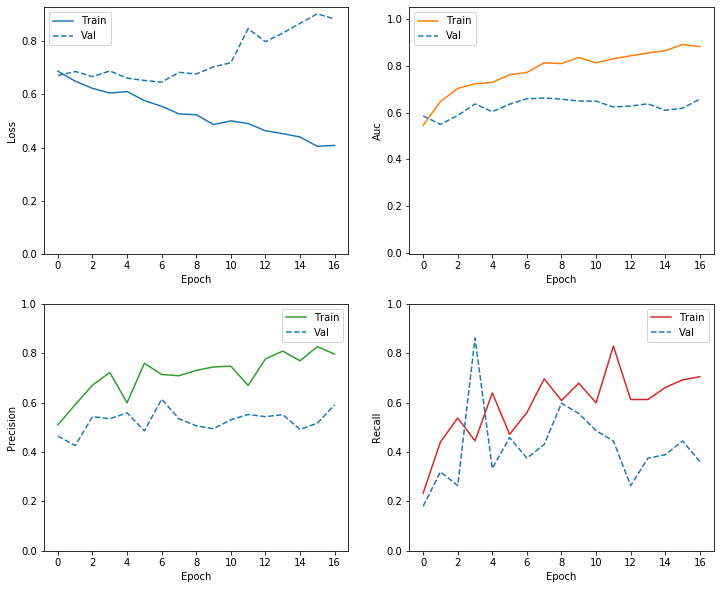

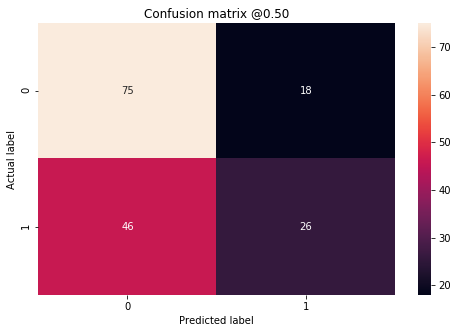

Legitimate Transactions Detected (True Negatives):  75
Legitimate Transactions Incorrectly Detected (False Positives):  18
Fraudulent Transactions Missed (False Negatives):  46
Fraudulent Transactions Detected (True Positives):  26
Total Fraudulent Transactions:  72
For the Modalities: Gaze-Mexp
[INFO] training model...
Train on 492 samples, validate on 165 samples
Epoch 1/100
480/492 [============================>.] - ETA: 1s - loss: 0.6315 - tp: 137.0000 - fp: 114.0000 - tn: 144.0000 - fn: 85.0000 - accuracy: 0.5854 - precision: 0.5458 - recall: 0.6171 - auc: 0.6678
Epoch 00001: val_auc improved from inf to 0.59289, saving model to best_modelgm.h5
492/492 [==============================] - 73s 149ms/sample - loss: 0.6299 - tp: 140.0000 - fp: 115.0000 - tn: 150.0000 - fn: 87.0000 - accuracy: 0.5894 - precision: 0.5490 - recall: 0.6167 - auc: 0.6693 - val_loss: 0.6504 - val_tp: 24.0000 - val_fp: 24.0000 - val_tn: 69.0000 - val_fn: 48.0000 - val_accuracy: 0.5636 - val_precision: 0.5000 

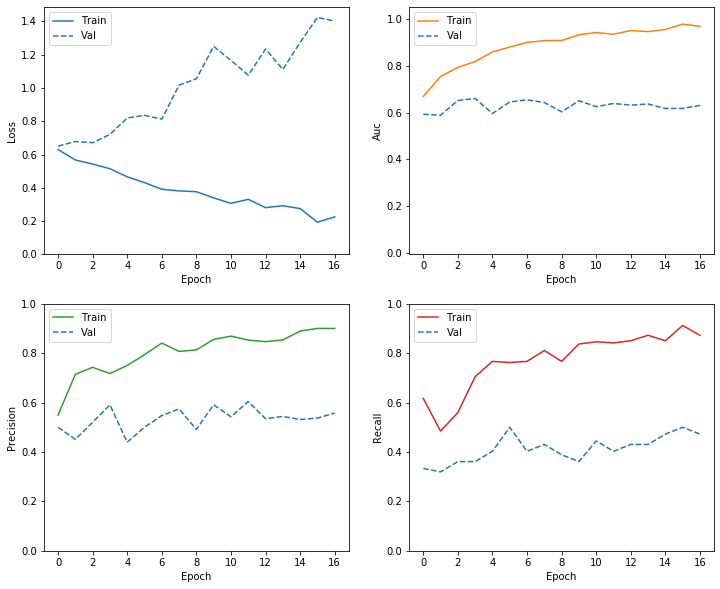

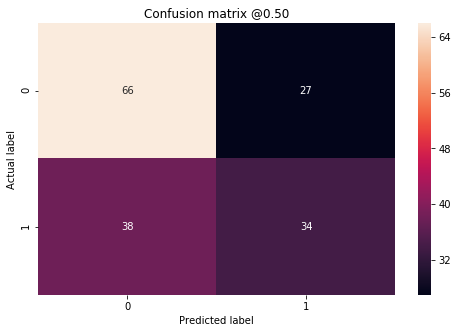

Legitimate Transactions Detected (True Negatives):  66
Legitimate Transactions Incorrectly Detected (False Positives):  27
Fraudulent Transactions Missed (False Negatives):  38
Fraudulent Transactions Detected (True Positives):  34
Total Fraudulent Transactions:  72
For the Modalities: Audio-Mexp
[INFO] training model...
Train on 492 samples, validate on 165 samples
Epoch 1/100
480/492 [============================>.] - ETA: 1s - loss: 0.4170 - tp: 181.0000 - fp: 33.0000 - tn: 222.0000 - fn: 44.0000 - accuracy: 0.8396 - precision: 0.8458 - recall: 0.8044 - auc: 0.9028
Epoch 00001: val_auc improved from inf to 0.61544, saving model to best_modelam.h5
492/492 [==============================] - 67s 137ms/sample - loss: 0.4127 - tp: 182.0000 - fp: 34.0000 - tn: 231.0000 - fn: 45.0000 - accuracy: 0.8394 - precision: 0.8426 - recall: 0.8018 - auc: 0.9039 - val_loss: 1.2760 - val_tp: 33.0000 - val_fp: 28.0000 - val_tn: 65.0000 - val_fn: 39.0000 - val_accuracy: 0.5939 - val_precision: 0.5410 -

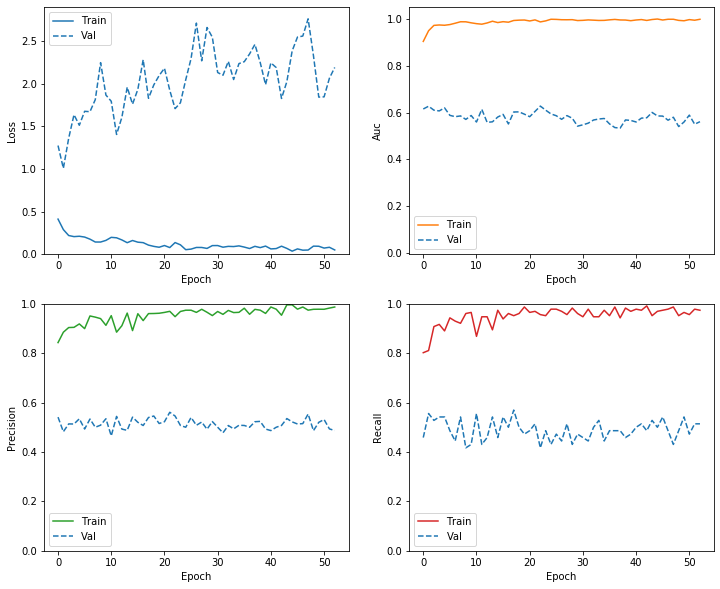

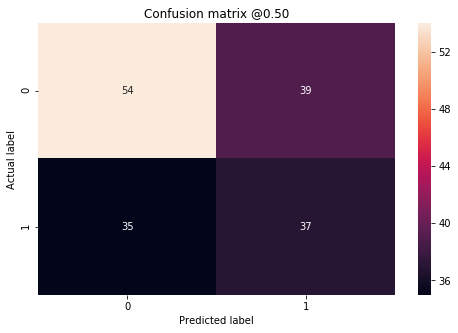

Legitimate Transactions Detected (True Negatives):  54
Legitimate Transactions Incorrectly Detected (False Positives):  39
Fraudulent Transactions Missed (False Negatives):  35
Fraudulent Transactions Detected (True Positives):  37
Total Fraudulent Transactions:  72
For the Modalities: Audio-Gaze-Mexp
[INFO] training model...
Train on 492 samples, validate on 165 samples
Epoch 1/100
480/492 [============================>.] - ETA: 2s - loss: 0.1996 - tp: 199.0000 - fp: 18.0000 - tn: 242.0000 - fn: 21.0000 - accuracy: 0.9187 - precision: 0.9171 - recall: 0.9045 - auc: 0.9793
Epoch 00001: val_auc improved from inf to 0.60872, saving model to best_modelagm.h5
492/492 [==============================] - 106s 216ms/sample - loss: 0.1949 - tp: 206.0000 - fp: 18.0000 - tn: 247.0000 - fn: 21.0000 - accuracy: 0.9207 - precision: 0.9196 - recall: 0.9075 - auc: 0.9803 - val_loss: 2.3298 - val_tp: 39.0000 - val_fp: 28.0000 - val_tn: 65.0000 - val_fn: 33.0000 - val_accuracy: 0.6303 - val_precision: 0

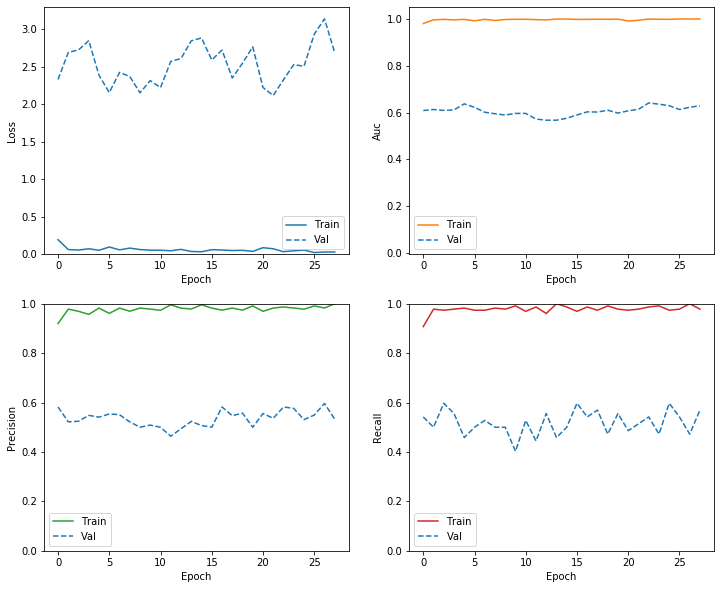

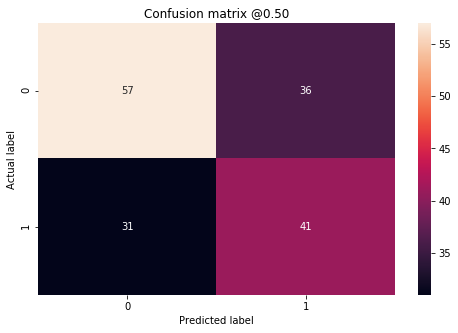

Legitimate Transactions Detected (True Negatives):  57
Legitimate Transactions Incorrectly Detected (False Positives):  36
Fraudulent Transactions Missed (False Negatives):  31
Fraudulent Transactions Detected (True Positives):  41
Total Fraudulent Transactions:  72


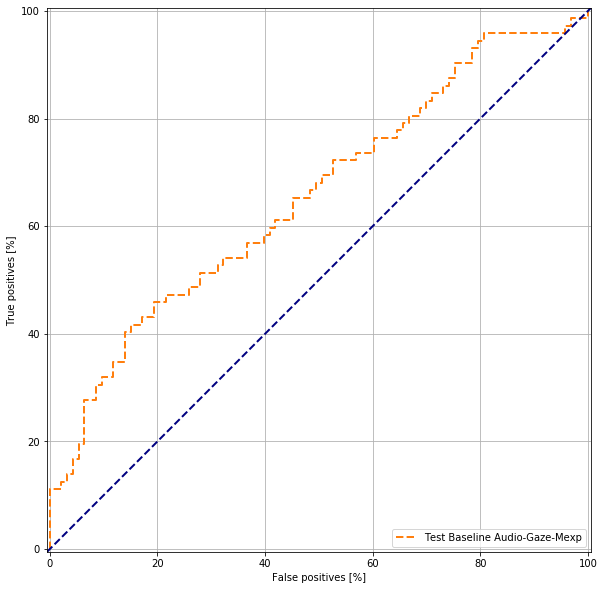

In [98]:
modaltypes = {'ag': 'Audio-Gaze', 'gm': 'Gaze-Mexp', 'am': 'Audio-Mexp', 'agm': 'Audio-Gaze-Mexp'}

for modaltype in ['ag', 'gm', 'am', 'agm']:
    print(f'For the Modalities: {modaltypes[modaltype]}')
    erstop = EarlyStopping(monitor='val_auc', mode='auto', verbose=1, patience=15)
    mdchck = ModelCheckpoint('best_model' +modaltype + '.h5', monitor='val_auc', mode='auto', verbose=1, save_best_only=True) 

    model = Model(inputs=inp[modaltype], outputs=out[modaltype])
    model.compile(optimizer = keras.optimizers.Adam(lr=1e-3), loss = keras.losses.BinaryCrossentropy(), metrics = METRICS)

    # train the model
    print("[INFO] training model...")
    history = model.fit(trainX[modaltype], y_train, validation_data = (testX[modaltype], y_test), epochs=100, callbacks = [erstop, mdchck])

    plot_metrics(history)
    plt.savefig('Loss_plot_' + modaltypes[modaltype] +'.png')

    #train_predictions_baseline = model.predict(trainX[modaltype])
    test_predictions_baseline = model.predict(testX[modaltype])

    baseline_results = model.evaluate(testX[modaltype], y_test, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
        print(f'{modaltypes[modaltype]}: \n')
        print(name, ': ', value)
    print()
    plot_cm(y_test, test_predictions_baseline)

    #plot_roc("Train Baseline "+ modaltypes[modaltype], y_train, train_predictions_baseline, color=colors[0])
    plot_roc("Test Baseline " + modaltypes[modaltype], y_test, test_predictions_baseline, color=colors[1], linestyle='--')
    plt.legend(loc='lower right')